In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dog Breed Identification
Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

## Acknowledgments

We extend our gratitude to the creators of the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) for making this competition possible: Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao, and Fei-Fei Li.

## Problem

Identifying the breed of as dog given an image of a dog.

## Data

The data we're using is from Kaggle's [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data) competition.

# Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image, as stated [here](https://www.kaggle.com/c/dog-breed-identification/overview/evaluation).

## Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breed of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (theses images have no labels, because we'll want to predict them).

## Workspace setup

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
print("TF Version: ", tf.__version__)
print("TF Hub Version: ", hub.__version__)
print("Hello") if tf.config.list_physical_devices else print("Yo")

TF Version:  2.3.0
TF Hub Version:  0.10.0
Hello


### Getting our data ready (Into Tensors)
Data has to be in numerical format.
Starting by accessing data and checking labels

In [ ]:
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/DogDataset/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     bd69b10022556a234eabafbbc5348bba  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


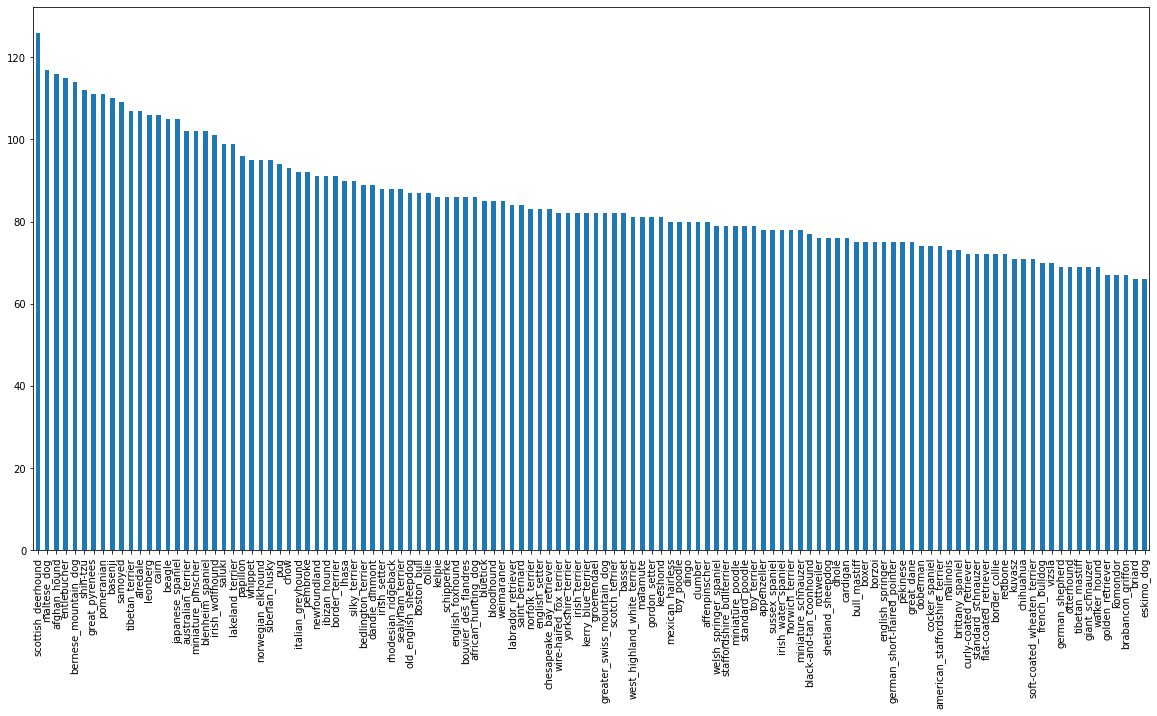

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize = (20,10));

In [ ]:
 labels_csv["breed"].value_counts().median()

82.0

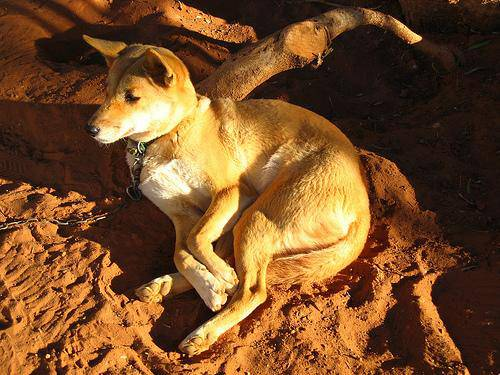

In [ ]:
from IPython.display import Image
Image("/content/drive/My Drive/DogDataset/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting images and their label
Getting a list of all out image pathnames

In [ ]:
filenames = ["/content/drive/My Drive/DogDataset/train/" + fname for fname in labels_csv["id"] + ".jpg"]
len(filenames)

10222

In [ ]:
import os
len(os.listdir("/content/drive/My Drive/DogDataset/train/")) == len(filenames)

False

### Preparing Labels

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# Checking if number of labels match with number of filenames

len(labels) == len(filenames)

True

In [ ]:
# Find unique breeds
set(labels)
unique_breeds = np.unique(labels)

In [ ]:
labels[0] ==  unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

## Creating our own validation set

Kaggle doesn't provide a validation set

In [ ]:
## Setting up X and y variables
X = filenames
y = boolean_labels

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting them into training and validation

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.2, random_state = 42 )

len(X_train), len(X_val), len(y_train), len(y_val)

(8177, 2045, 8177, 2045)

## Preprocessing Images
Turning images into Tensors.

In [ ]:

### Function for converting images into Tensors
  # Define Size
IMG_SIZE = 224
# Create a function for preprossing images

def process_image(image_path):

  # Read an image file
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical tensor
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)

  # Resizing the image
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

#### Turning our data into Batches

Memory might not be enough to process 10,000+ images. 

We do it in batches of 32

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`

In [ ]:
def get_image_label(image_path, label):

  image = process_image(image_path)
  return image, label


Making a function to turn all of our data X and y into batches

In [ ]:
# Define the batch size: 32

BATCH_SIZE = 32

# Create a function to turn data into batches

def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):

  # If the data is the test data set, we don't have labels
  if test_data:
    print('Creating test data batches . . . .')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))   # Only filepaths no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

    # If the data is a valid data set, we don't need to shuffle it

  elif valid_data:
    print("Creating validation data batches . . . ")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) #Also preprocesses the images 
    return data_batch

  else:
    print("Creating training data batches . . . . ")    
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling the pathnames before mapping and processing 
    data = data.shuffle(buffer_size = len(X))

    data = data.map(get_image_label)

    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [ ]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches . . . . 
Creating validation data batches . . . 


## Building a model

Things to define:
* The `input` shape  (int he form of tensors)
* The `output` shape (iamge labels, in the form of tensors)
* URL of the model we want to use


In [ ]:
INPUT_SHAPE = [None, IMG_SIZE,IMG_SIZE,3]

OUTPUT_SHAPE= len(unique_breeds)

# Setup model URL from TensorFlow HUB

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [ ]:
# Creating a function with creates a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with: ", MODEL_URL)

  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
                               tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                                                    activation = "softmax")
                               ])
  #Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  #Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks
Callbacks are helper functions a model can use during training to do such things such as save its progress, check its progress or stop trianing early if a model stops improving.

Create two callbacks:
 One for TensorBoard, which helps track our model's progress and another for early stopping which prevents our models from training for too long.

 ### TensorBoard Callbacks
 1. Load the TensorBoard notebook extension
 2. Create a TensorBoard callback whoch is able to save logs to a directory and pass it to our model's `fit()` function.
 3. Visualize our models training logs with the `%tensorboard` magic function.

In [ ]:
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  log_dir = os.path.join("DogDataset/logs",
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
### Early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "accuracy", patience = 3)

### Training Model


In [ ]:
NUM_EPOCHS = 100

In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:

# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [32]:
# Fitting the model to the data
model = train_model() 

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
  2/256 [..............................] - ETA: 1:06 - loss: 5.4924 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1267s vs `on_train_batch_end` time: 0.3939s). Check your callbacks.


256/256 [==============================] - 308s 1s/step - loss: 1.4879 - accuracy: 0.6385 - val_loss: 0.7370 - val_accuracy: 0.7985
Epoch 2/100
256/256 [==============================] - 52s 202ms/step - loss: 0.4145 - accuracy: 0.8830 - val_loss: 0.6569 - val_accuracy: 0.8093
Epoch 3/100
256/256 [==============================] - 51s 198ms/step - loss: 0.2372 - accuracy: 0.9400 - val_loss: 0.6611 - val_accuracy: 0.8137
Epoch 4/100
256/256 [==============================] - 51s 198ms/step - loss: 0.1474 - accuracy: 0.9694 - val_loss: 0.6777 - val_accuracy: 0.8093
Epoch 5/100
256/256 [==============================] - 51s 198ms/step - loss: 0.1020 - accuracy: 0.9828 - val_loss: 0.6853 - val_accuracy: 0.8112
Epoch 6/100
256/256 [==============================] - 51s 197ms/step - loss: 0.0741 - accuracy: 0.9885 - val_loss: 0.6829 - val_accuracy: 0.8132
Epoch 7/100
256/256 [==============================] - 51s 197ms/step - loss: 0.0559 - accuracy: 0.9939 - val_loss: 0.7014 - val_accuracy:

### Making and evaluating predictions using a trained model

In [33]:
# Make predictions on the validatin data (not useed to train on)
predictions = model.predict(valid_data, verbose = 1)
predictions

64/64 [==============================] - 10s 152ms/step


array([[7.7371443e-10, 7.2158213e-12, 3.6406322e-09, ..., 2.2906239e-09,
        2.7183801e-06, 5.8696568e-08],
       [2.0404867e-10, 4.7360242e-08, 2.8761760e-10, ..., 4.3254239e-10,
        1.6857408e-11, 7.6963966e-07],
       [2.1534206e-08, 3.3730461e-07, 3.9638678e-08, ..., 2.0360490e-06,
        1.4249025e-06, 4.1795443e-09],
       ...,
       [7.1523920e-10, 3.2969622e-06, 1.5810744e-10, ..., 4.3492634e-10,
        2.0488127e-07, 1.3518169e-06],
       [2.2531030e-13, 1.6622019e-10, 1.3936742e-11, ..., 3.2605500e-12,
        8.3673152e-10, 1.4836115e-12],
       [2.5294401e-07, 2.3699180e-09, 9.4187143e-08, ..., 2.7871154e-08,
        3.4795047e-10, 2.3523755e-10]], dtype=float32)

In [ ]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value: {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")

In [35]:
def get_pred_label(prediction_probabilities):

  return unique_breeds[np.argmax(prediction_probabilities)]

In [36]:
pred_label = get_pred_label(predictions[81])
pred_label

'entlebucher'

In [37]:
valid_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

Since data is still in batch dataset, we'll have to take it out of the batches, to make predictions on the validation images. 

In [38]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(valid_data)

In [41]:
import matplotlib.pyplot as plt

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  
  # Get the pred label
  pred_label = get_pred_label(pred_prob)
  
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)

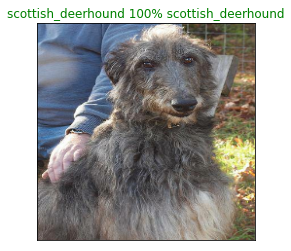

In [42]:
plot_pred(predictions, val_labels, val_images, 2)

In [46]:
# save the model
def save_model(model, suffix = None):

  modeldir = os.path.join("/content/drive/My Drive/DogDataset/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + "suffix"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [47]:
# Create a function to laod a trained model

def load_model(model_path):
    model = keras.models.load_model(model_path)
    return model

In [48]:
save_model(model, "1000-images-Adam-mobilenetv2")

Saving model to: /content/drive/My Drive/DogDataset/models/20201116-071909-suffix...
INFO:tensorflow:Assets written to: /content/drive/My Drive/DogDataset/models/20201116-071909-suffix/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/DogDataset/models/20201116-071909-suffix/assets


'/content/drive/My Drive/DogDataset/models/20201116-071909-suffix'

In [50]:
import keras

In [51]:
loaded_model = load_model('/content/drive/My Drive/DogDataset/models/20201116-071909-suffix')

In [52]:
loaded_model.evaluate(valid_data)

64/64 [==============================] - 9s 146ms/step - loss: 0.8710 - accuracy: 0.8088


[0.8710023164749146, 0.8088019490242004]

## Making predictions on the test data test

* We'll have to convert them into Tensor Batches

Steps
1. Get the test image filenames
2. Conver the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True`.
3. Make a predictions array by passing the test batches to the `predict()` method called on out model.

In [59]:
# Load test image filenames
test_path = "/content/drive/My Drive/DogDataset/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [60]:
# Create a test data batch

test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches . . . .


In [61]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [62]:
# Going to take a really long time
test_predictions = loaded_model.predict(test_data,verbose=1)

  7/324 [..............................] - ETA: 55:33

KeyboardInterrupt: ignored